In [14]:

#!/usr/bin/env python
# -*- coding: utf-8 -*-
# @Time    : 2022/10/08 13:58
# @Author  : Wang Yujia
# @File    : PT_demo.ipynb

# @Description : 1. 用SA试做一下inference of PT model's 3 params 2. 复现table 1的code见PT_demo_table1.ipynb

# 1. Preparations
## 1.1 Import

In [15]:

import numpy as np
import pandas as pd
import sympy
import time
import datetime
from sko.tools import set_run_mode
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
#from sko.SA import SABoltzmann
from SA_PT import SABoltzmann as SABoltzmann
import multiprocessing
from multiprocessing.dummy import Pool

## 1.2 Global Settings

In [16]:
# auction settings from Swoopo
#b = 0.75
#v = 169.99
#d = 0.15

# auction settings from paper's Fig.1 left
b= 0.75
v = 27.99
d = 0.01

# cnt_row = data_i.shape[0]
cnt_row = 5
# cnt_n_2 = data_i['cnt_n_2']
cnt_n_2 = [1,1,2,3,1]
#N_i = data_i['N']
N_i = [500,50,100,200,300]
# max duration from Swoopo
max_T = 831

# from paper's Table 5 'All auction'
# alpha = 0.025
# delta = 0.85
# labda = 3.72

# initial params
table_5_M = [0.025,0.85,3.72]
# lower/ upper bound
lb = [-0.3,0.01,0.01]
ub = [0.3, 2, 16]

# paper setting
#T = int((v-b)/d)

# 2. Infer with SA
1. 用SA 求解参数。
2. 定义函数之后，求一个uniq auction下的u和p
3. 然后用p求NLL作为最终的loss

## 2.1 function definition
1. 根据Eq(7)-(9)

In [17]:
def C(t,b):
    return 0.2*t*b

def OMEGA(p,delta):
    return p**delta * ((p**delta + (1-p)**delta)**(-1/delta))

# valuation function
def f(x, alpha):
    return (1-sympy.E**(-alpha*x))/alpha
    # when x < 0, in fact, it shoule be : (-labda)*(1-sympy.E**(alpha*x))/alpha

def f_Equi(t,v,d,b,alpha,labda,delta):
    u = sympy.Symbol('u')

    tmp = v-d*t-C(t-1,b) - b

    func_1 = (labda * f(x=C(t-1, b), alpha=alpha) - labda * OMEGA(u, delta) * f(x=(C(t-1, b) + b), alpha=alpha) + OMEGA(1-u, delta) * f(tmp, alpha))
    func_2 = (-f(x=C(t-1, b), alpha=alpha) + OMEGA(u, delta) * f(x=(C(t-1, b) + b), alpha=alpha) + (1 - OMEGA(u, delta)) * f(-tmp, alpha))

    if(tmp >= 0):
        return sympy.nsolve(func_1,(0,1),solver='bisect', verify=False)
    else:
        return sympy.nsolve(func_2,(0,1),solver='bisect', verify=False)

## 2.2 Loss func
1. 这个函数比较长 没办法，求u需要用SA给的params的值。`loss_func`的返回值是NLL
2. 求解`U_i[t]` which is a array with shape of (max(N)),`U_i[t]`就是paper里的`p_t`
3. for different auction, the duration is N_i[idx] and the value of duration it is various
4. nll计算时乘的`cnt_n_2[idx]`是为了减少计算次数，表示duration相同的auction的数量。

In [18]:
def loss_func(params):

    start_time = datetime.datetime.now()

    alpha = params[0]
    delta = params[1]
    labda = params[2]

    # solve for U from Equi. condt.
    U_i = [0] * (max_T + 1)
    U_i[0] = 1

    for t in range(1,max_T+1):
        U_i[t] = f_Equi(t, v, d, b, alpha, labda, delta)

    # calculate NLL under this auction setting & PT params
    nll = 0
    if(U_i[0]==1):
        U_i.pop(0)            # because U_i[0]=1
    U_tmp_df = pd.DataFrame(U_i, index=np.arange(0, U_i.__len__()), columns=['U'], dtype=float)
    # cnt_row = data_i.shape[0]
    for idx in range(0,cnt_row):
        # sum up the log prob among all durations of this auction
        nll += ( np.sum(U_tmp_df[0:(N_i[idx]-1)][:].apply(np.log,axis=1)) + np.log(1-U_tmp_df.iat[(N_i[idx]-1),0]) )* cnt_n_2[idx]

    print('loss_func costs {time_costs}s \n'.format(time_costs=(datetime.datetime.now() - start_time).total_seconds()))
    return float(-nll)

In [19]:
# for SA testing
def demo_func(x,settings):
    alpha = x[0]
    delta = x[1]
    labda = x[2]

    v,d,b = settings[0], settings[1], settings[2]

    print("what the settings: ",v,d,b)
    return alpha ** 2 + (labda - 0.05) ** 2 + delta ** 2

In [32]:
def task():

    #set_run_mode(loss_func, 'cached')
    #set_run_mode(loss_func, 'multithreading')
    sa_boltzmann = SABoltzmann(func=demo_func, x0=table_5_M, settings=[v,d,b],T_max=1000, T_min=1e-5, learn_rate=0.01, L=50, max_stay_counter=50,
                                lb=lb, ub=ub)
    print("> Now do SA....... \n")

    sa_boltzmann.run()

    print("SA ends \n")

In [ ]:
#多线程测试，一点都不work超级慢。
if __name__ == '__main__':
    multiprocessing.freeze_support() # 在Windows下编译需要加这行
    print("The num of CPU of this computer is : ",multiprocessing.cpu_count())
    # 生成进程池
    pool = Pool(3)
    # 添加进程
    p1 = pool.map_async(task, args=(1,[[],[],[]]))

    # 不再添加进程
    pool.close()

    # 主程序等待所有进程完成
    pool.join()

    # 获取进程函数返回值(如果任务存在返回值)
    p1_value = p1.get()

    print(f'进程1返回值：{p1_value}')


The num of CPU of this computer is :  16
> Initilizing SA....... 

> Now it's 1th thread working....
> Initilizing SA....... 
> Initilizing SA....... 

> Now it's 3th thread working....

> Now it's 2th thread working....
loss_func costs 153.6453s 

> Now do SA....... 

-------------- 0_th iteration --------------

---------- 0/L ----------

x_new before clipping:  [-0.09289457  1.06578648  3.45896887]
loss_func costs 173.641584s 

> Now do SA....... 

-------------- 0_th iteration --------------

---------- 0/L ----------

x_new before clipping:  [-0.10655365  0.65460869  3.37978113]
loss_func costs 358.544551s 

> Now do SA....... 

-------------- 0_th iteration --------------

---------- 0/L ----------

x_new before clipping:  [-0.1358566   0.83489664  3.11945265]


D:\Anaconda\envs\pythorch\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log


loss_func costs 386.741335s 

y_new - y_current is inf: 
---------- 1/L ----------

x_new before clipping:  [-0.08222353  0.95233763  3.86303469]
loss_func costs 427.53907s 

y_new - y_current is 72.57871859552466: 
---------- 1/L ----------

x_new before clipping:  [-0.16836859  1.01228969  3.21606296]


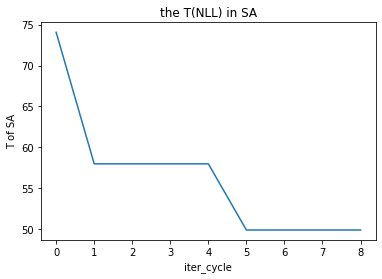

best x:  [-0.29344945  0.45054186  7.72721328]
best y:  49.91387101249883


In [17]:
# # draw and print
# plt.title("the T(NLL) in SA")
# plt.xlabel("iter_cycle")
# plt.ylabel("T of SA")
# sns.lineplot(x = np.arange(0,sa_boltzmann.iter_cycle+1),y=np.array(sa_boltzmann.generation_best_Y))
# plt.show()
# print("best x: ",sa_boltzmann.best_x)
# print("best y: ",sa_boltzmann.best_y)

In [ ]:
# alpha_g = -0.1
# def g(x):
#     return (1-np.exp(-alpha_g*x))/alpha_g
#
# x_g = pd.DataFrame(np.arange(0,100),index=(np.arange(0,100)),columns=['x'])
# x_g['y'] = x_g.apply(g,axis=1)
# sns.scatterplot(x = x_g['x'],y=x_g['y'])

#3. calculate P
1. infer结束后可以用param计算P，
2. 方法无非是先算u再算p,然后把p对应着key输出到字典里

In [ ]:
alpha = 0.025
delta = 0.85
labda = 3.72

# solve for U&P from Equi. condt.
U_i = [0] * (max_T + 1)
U_i[0] = 1
P_tmp = [0]*(max_T+1)   # P is what we want to generate
P_tmp[0] = 1

tmp = 1

for t in range(1,max_T+1):

    U_i[t] = f_Equi(t, v, d, b, alpha, labda, delta)
    P_tmp[t] = (1- U_i[t])*tmp
    tmp = tmp*U_i[t]

# 4. 多线程实验，多跑几个core

In [4]:
    sa_boltzmann = SABoltzmann(func=demo_func, x0=table_5_M, settings=[v,d,b],T_max=1000, T_min=1e-5, learn_rate=0.01, L=50, max_stay_counter=50,
                                lb=lb, ub=ub)